# Why Deterministic Models Are Risky: What Breaks When You Ignore Uncertainty

This notebook demonstrates what actually breaks when you use deterministic models without accounting for uncertainty.

Understanding this is critical because:
- **Deterministic models** assume perfect information (demand = 1,000 exactly)
- **Reality** is uncertain and variable (demand could be 800, 1,000, or 1,200)
- Recommendations that look optimal can fail catastrophically when conditions change
- Without testing under uncertainty, you're gambling with your decisions


## Key Concepts

**Deterministic Assumptions**:
- Assume you know inputs exactly (demand = 1,000 units)
- Model finds "optimal" solution based on these fixed inputs
- Solution looks perfect on paper

**The Problem**:
- Real inputs are uncertain and variable
- When reality differs from assumptions, the "optimal" solution breaks
- You can't see this risk until it's too late

**Critical insight**: A solution that's optimal under perfect conditions might be terrible when conditions vary. Deterministic models hide this risk, making you overconfident.


## Scenario: Production Scheduling Decision

You manage a factory and need to schedule production. You use an optimization model that assumes:
- Machine downtime will be exactly 5% (based on historical average)
- Material deliveries will always arrive on time
- All workers will be available

The model recommends a tight production schedule that maximizes output.

**The risk**: What happens when reality doesn't match these perfect assumptions?


## Step 1: Install Required Packages (Colab)


In [1]:
# Install required packages (if needed in Colab)
%pip install numpy matplotlib pandas -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)


## Step 3: Deterministic Model - Perfect Assumptions

Let's build a deterministic model with perfect assumptions:


In [3]:
# DETERMINISTIC MODEL: Perfect assumptions
# We assume we know everything exactly

# Fixed inputs (assumed to be certain)
machine_downtime_rate = 0.05  # Exactly 5% downtime
available_hours_per_day = 8
days_per_month = 20
total_available_hours = available_hours_per_day * days_per_month * (1 - machine_downtime_rate)

# Production parameters
units_per_hour = 10  # Production rate
target_units = 1500  # Production target

# Calculate required hours
required_hours = target_units / units_per_hour

# Deterministic result
can_complete = required_hours <= total_available_hours
completion_rate = min(1.0, total_available_hours / required_hours) if required_hours > 0 else 1.0

print("DETERMINISTIC MODEL RESULT:")
print(f"  Assumed downtime: {machine_downtime_rate*100:.1f}%")
print(f"  Available hours: {total_available_hours:.1f} hours")
print(f"  Required hours: {required_hours:.1f} hours")
print(f"  Can complete target: {'Yes' if can_complete else 'No'}")
print(f"  Completion rate: {completion_rate*100:.1f}%")
print(f"\n✅ Model says: 'This schedule will work!'")
print(f"⚠️  But what if downtime isn't exactly 5%?")


DETERMINISTIC MODEL RESULT:
  Assumed downtime: 5.0%
  Available hours: 152.0 hours
  Required hours: 150.0 hours
  Can complete target: Yes
  Completion rate: 100.0%

✅ Model says: 'This schedule will work!'
⚠️  But what if downtime isn't exactly 5%?


## Step 4: Reality - What Actually Happens

Now let's see what happens when reality doesn't match our perfect assumptions:


In [4]:
# REALITY: Downtime varies month to month
# Some months it's 3%, some months it's 8%
# The deterministic model assumed it's always 5%

def calculate_completion(downtime_rate):
    """Calculate completion rate for a given downtime rate"""
    available = available_hours_per_day * days_per_month * (1 - downtime_rate)
    required = required_hours
    return min(1.0, available / required) if required > 0 else 1.0

# Simulate 12 months of actual downtime
num_months = 12
# Downtime varies: mean 5%, but can be 3% to 8%
actual_downtime = np.random.normal(loc=0.05, scale=0.015, size=num_months)
actual_downtime = np.clip(actual_downtime, 0.03, 0.08)  # Keep within 3-8% range

# Calculate actual completion rates
actual_completion = [calculate_completion(dt) for dt in actual_downtime]
actual_completion = np.array(actual_completion)

# Count failures (completion < 100%)
failures = (actual_completion < 1.0).sum()
failure_rate = failures / num_months * 100

print("REALITY CHECK (12 months of actual operations):")
print(f"  Assumed downtime: {machine_downtime_rate*100:.1f}% (fixed)")
print(f"  Actual downtime range: {actual_downtime.min()*100:.1f}% to {actual_downtime.max()*100:.1f}%")
print(f"  Average actual downtime: {actual_downtime.mean()*100:.1f}%")
print(f"\n  Months where schedule FAILED: {failures} out of {num_months} ({failure_rate:.1f}%)")
print(f"  Average completion rate: {actual_completion.mean()*100:.1f}%")
print(f"  Worst month completion: {actual_completion.min()*100:.1f}%")
print(f"\n❌ The 'optimal' schedule fails {failure_rate:.1f}% of the time!")
print(f"   This is what deterministic models hide from you.")


REALITY CHECK (12 months of actual operations):
  Assumed downtime: 5.0% (fixed)
  Actual downtime range: 4.3% to 7.4%
  Average actual downtime: 5.4%

  Months where schedule FAILED: 2 out of 12 (16.7%)
  Average completion rate: 99.8%
  Worst month completion: 98.8%

❌ The 'optimal' schedule fails 16.7% of the time!
   This is what deterministic models hide from you.


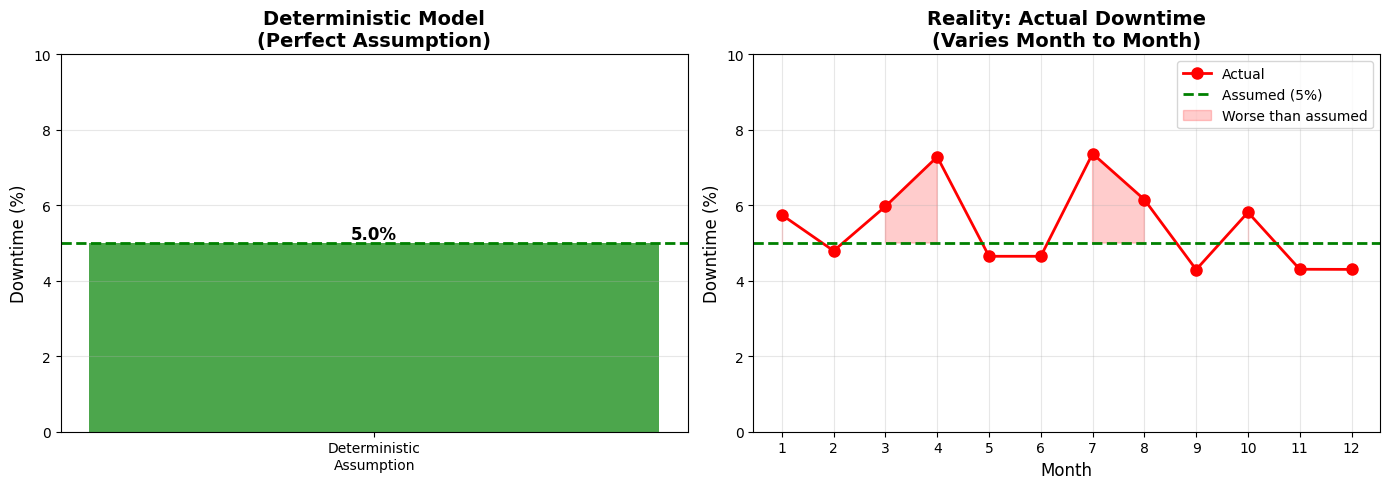


🔍 KEY INSIGHT:
   Deterministic model assumes downtime is ALWAYS 5%.
   Reality shows it VARIES from 3% to 8%.
   When it's higher than 5%, the schedule fails!


In [5]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Deterministic assumption
ax1.bar(['Deterministic\nAssumption'], [machine_downtime_rate*100], color='green', alpha=0.7, label='Assumed')
ax1.axhline(machine_downtime_rate*100, color='green', linestyle='--', linewidth=2)
ax1.set_ylabel('Downtime (%)', fontsize=12)
ax1.set_title('Deterministic Model\n(Perfect Assumption)', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 10)
ax1.grid(axis='y', alpha=0.3)
ax1.text(0, machine_downtime_rate*100, f'{machine_downtime_rate*100:.1f}%', 
         ha='center', va='bottom', fontsize=12, fontweight='bold')

# Right plot: Reality (actual downtime over 12 months)
months = range(1, num_months + 1)
ax2.plot(months, actual_downtime*100, 'o-', color='red', linewidth=2, markersize=8, label='Actual')
ax2.axhline(machine_downtime_rate*100, color='green', linestyle='--', linewidth=2, label='Assumed (5%)')
ax2.fill_between(months, actual_downtime*100, machine_downtime_rate*100, 
                 where=(actual_downtime*100 > machine_downtime_rate*100), 
                 color='red', alpha=0.2, label='Worse than assumed')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Downtime (%)', fontsize=12)
ax2.set_title('Reality: Actual Downtime\n(Varies Month to Month)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 10)
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.show()

print("\n🔍 KEY INSIGHT:")
print("   Deterministic model assumes downtime is ALWAYS 5%.")
print("   Reality shows it VARIES from 3% to 8%.")
print("   When it's higher than 5%, the schedule fails!")


## Step 6: The Cost of Failure

Let's quantify what these failures actually cost:


In [6]:
# Calculate costs of failures
penalty_per_missing_unit = 50  # Cost of missing delivery deadline
units_short = target_units * (1 - actual_completion)
total_penalty = (units_short * penalty_per_missing_unit).sum()

# Calculate what a robust schedule would cost
# A robust schedule would plan for worst-case downtime (8%)
robust_downtime = 0.08
robust_available = available_hours_per_day * days_per_month * (1 - robust_downtime)
robust_target = robust_available * units_per_hour
opportunity_cost_per_unit = 20  # Profit lost from producing less
opportunity_cost = (target_units - robust_target) * opportunity_cost_per_unit

print("COST ANALYSIS:")
print(f"\n❌ Cost of failures (deterministic schedule):")
print(f"   Total penalty from missed deadlines: ${total_penalty:,.2f}")
print(f"   Average penalty per month: ${total_penalty/num_months:,.2f}")
print(f"\n✅ Cost of robust schedule (planning for 8% downtime):")
print(f"   Would produce: {robust_target:.0f} units (vs {target_units} target)")
print(f"   Opportunity cost: ${opportunity_cost:,.2f}")
print(f"   But: ZERO penalty from failures")
print(f"\n💡 TRADE-OFF:")
print(f"   Deterministic: Higher target, but {failure_rate:.0f}% failure rate = ${total_penalty:,.0f} penalties")
print(f"   Robust: Lower target, but 0% failure rate = $0 penalties")
print(f"\n   Net difference: ${total_penalty - opportunity_cost:,.2f}")
if total_penalty > opportunity_cost:
    print(f"   → Robust schedule is BETTER despite lower target!")
else:
    print(f"   → Deterministic schedule is better, but risky")


COST ANALYSIS:

❌ Cost of failures (deterministic schedule):
   Total penalty from missed deadlines: $1,722.69
   Average penalty per month: $143.56

✅ Cost of robust schedule (planning for 8% downtime):
   Would produce: 1472 units (vs 1500 target)
   Opportunity cost: $560.00
   But: ZERO penalty from failures

💡 TRADE-OFF:
   Deterministic: Higher target, but 17% failure rate = $1,723 penalties
   Robust: Lower target, but 0% failure rate = $0 penalties

   Net difference: $1,162.69
   → Robust schedule is BETTER despite lower target!


## Step 7: What This Teaches Us

Let's visualize the completion rates to see the pattern:


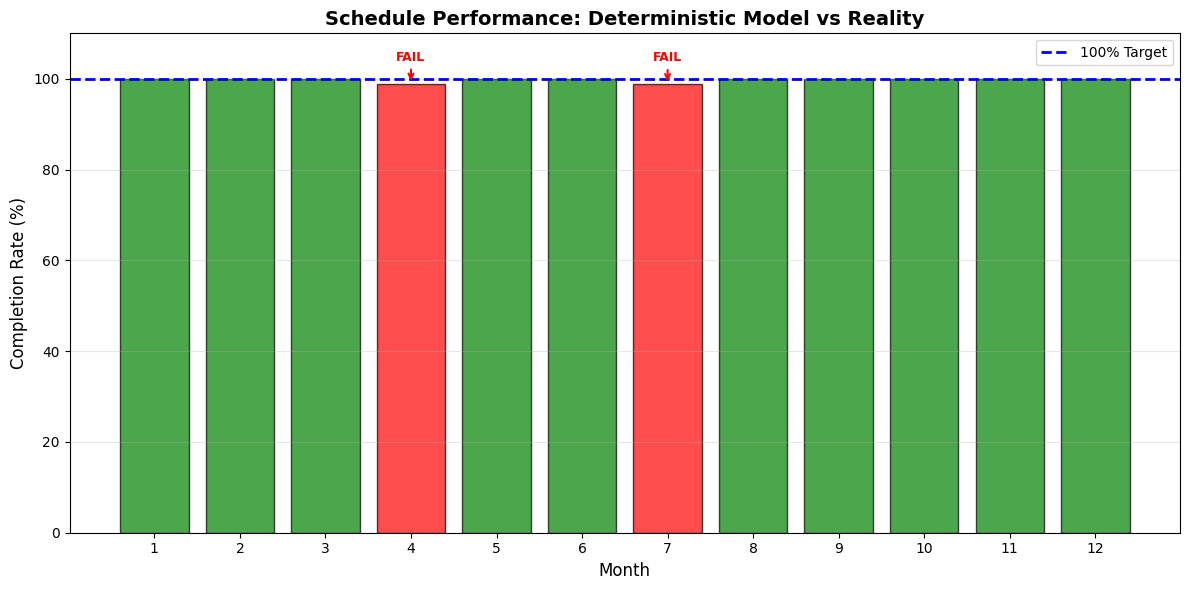


📊 SUMMARY:
   Months meeting target: 10 (83.3%)
   Months failing target: 2 (16.7%)

⚠️  The deterministic model said this schedule would work.
   But in reality, it fails 16.7% of the time!

💡 This is why we need simulation - to see these risks BEFORE implementation.


In [7]:
# Visualize completion rates
fig, ax = plt.subplots(figsize=(12, 6))

months = range(1, num_months + 1)
colors = ['red' if c < 1.0 else 'green' for c in actual_completion]
ax.bar(months, actual_completion*100, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(100, color='blue', linestyle='--', linewidth=2, label='100% Target')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Completion Rate (%)', fontsize=12)
ax.set_title('Schedule Performance: Deterministic Model vs Reality', fontsize=14, fontweight='bold')
ax.set_ylim(0, 110)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(months)

# Add failure annotations
for i, (month, completion) in enumerate(zip(months, actual_completion)):
    if completion < 1.0:
        ax.annotate('FAIL', xy=(month, completion*100), 
                   xytext=(month, completion*100 + 5),
                   ha='center', fontsize=9, fontweight='bold', color='red',
                   arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

plt.tight_layout()
plt.show()

print("\n📊 SUMMARY:")
print(f"   Months meeting target: {num_months - failures} ({100-failure_rate:.1f}%)")
print(f"   Months failing target: {failures} ({failure_rate:.1f}%)")
print(f"\n⚠️  The deterministic model said this schedule would work.")
print(f"   But in reality, it fails {failure_rate:.1f}% of the time!")
print(f"\n💡 This is why we need simulation - to see these risks BEFORE implementation.")


## Key Takeaways

1. **Deterministic models create false confidence**: They assume perfect information and make recommendations look certain, but reality is uncertain.

2. **Optimal solutions can fail**: A solution that's optimal under perfect assumptions can fail catastrophically when conditions vary.

3. **Failures have real costs**: When schedules fail, deadlines are missed, customers are disappointed, and money is lost.

4. **You can't see the risk until it's too late**: Without simulation, you don't know a recommendation is fragile until it fails in practice.

5. **Robust solutions may be better**: A slightly less optimal but more robust solution can outperform an optimal but fragile one when you account for uncertainty.

**Next steps**: In the next notebook, we'll learn how Monte Carlo simulation works to reveal these risks before implementation.
